In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
import config
import nrrd
import multiprocessing

from model_structures.models_together import UNet3D
from tqdm import tqdm
from copy import deepcopy as copy

In [5]:
# Load the PyTorch model
model_path = "./saved_models/KESM/model_for_vasc_3d_2l_3133612.pth"
num_of_layers = int(model_path.split("_")[-2][0])
model = UNet3D(num_of_layers)
model.load_state_dict(torch.load(model_path, map_location="cpu"))

# Set the model to evaluation mode
model.eval()

# Directory paths for input and output data
# input_dir = "./preparations/data/indata"
# output_dir = "./preparations/data/outdata"

# Get a list of image files in the input directory
# image_files = os.listdir(input_dir)

def get_prediction(img, margin):
    if margin != 0:
        raise ValueError
    with torch.no_grad():
        input_tensor = torch.from_numpy(img).unsqueeze(0).float()
        output = model(input_tensor)
    output_np = output.numpy()
    return output_np


In [6]:
# Paths to the input and output numpy arrays
input_file = "./unprocessed_data/KESM/volume_input.npy"
output_file = "./unprocessed_data/KESM/volume_ground_truth.npy"

# Load the input and output arrays
input_images_init = np.load(input_file)
label_images_init = np.load(output_file)

# Appy flat field correction


start_index = random.randint(0, len(input_images_init) - config.NUM_PICS - 1)
start_index = len(input_images_init) - config.NUM_PICS - 1

# Choose 16 consecutive images starting from the random index
shape = label_images_init[0].shape

while True:
    random_x, random_y = random.randint(0, shape[0] - config.WIDTH - 1), random.randint(0, shape[1] - config.HEIGHT - 1)
    random_x = shape[0] - config.WIDTH
    random_y = 0
    # Initialize an empty list to store the images
    image_list = input_images_init[start_index:start_index + config.NUM_PICS, random_x:random_x + config.WIDTH, random_y:random_y + config.HEIGHT]
    label_list = label_images_init[start_index:start_index + config.NUM_PICS, random_x:random_x + config.WIDTH, random_y:random_y + config.HEIGHT]

    # Convert the list of images into a NumPy array
    if(np.sum(label_list) > 0):
        break
print("Random x, y", random_x, random_y)

image_array = np.array([image_list])
label_list = np.array(label_list)

# Normalize image_array and label_list
image_min, image_max = np.min(image_array), np.max(image_array)
label_min, label_max = np.min(label_list), np.max(label_list)
image_array = (image_array - image_min) / (image_max - image_min)
label_list = (label_list - label_min) / (label_max - label_min)

print(image_array.shape)

# Perform inference using the model
with torch.no_grad():
    input_tensor = torch.from_numpy(image_array).unsqueeze(0).float()
    output = model(input_tensor)
# Convert the output tensor to a NumPy array
output_np = output.numpy()
# Convert the output prediction to binary format and multiply by 255
binary_output = (output_np >= 0.5).astype(np.uint8)[0][0]

shape = binary_output.shape
result_array = np.zeros(shape + (3,), dtype=np.uint8)

# Where both are 0
result_array[(label_list == 0) & (binary_output == 0), :] = (0, 0, 0)
# Where both are 255
result_array[(label_list == 1) & (binary_output == 1), :] = (255, 255, 255)
# Where label_image is 0 and binary_output is 255
result_array[(label_list == 0) & (binary_output == 1), :] = (0, 0, 255)
# Where label_image is 255 and binary_output is 0
result_array[(label_list == 1) & (binary_output == 0), :] = (0, 128, 128)

img_in = result_array
print("img_in", img_in.shape)
new_img = np.array([cv2.resize(x, (512, 512)) for x in img_in])
print("new_img", new_img.shape)

# Display the frames in OpenCV window
for i in range(len(new_img)):
    # Display the frame in OpenCV window
    first_img = new_img[i]
    second_img = cv2.resize(np.repeat(image_array[0][i][:, :, np.newaxis], 3, axis=-1), (512, 512))
    img_concat = np.concatenate((first_img, second_img), axis=1)

    # img_concat = np.concatenate(first_img, np.repeat(cv2.resize(image_array[0][i], (512, 512))[:, :, :, np.newaxis], 3, axis=-1)), axis=1)
    cv2.imshow('Frames', img_concat)
    cv2.waitKey(0)
cv2.destroyAllWindows()
    


print(new_img.shape)
# cv2.imshow("Input Image", cv2.resize(image_array, (512, 512)))
# cv2.imshow("Label Image", cv2.resize(label_list, (512, 512)))
# cv2.imshow("Model Prediction (Binary)", cv2.resize(binary_output, (512, 512)))
# cv2.imshow("Correctness Image", cv2.resize((np.multiply(binary_output, label_image) + np.multiply((255 - binary_output), (255 - label_image))) * 255, (512, 512)))

TP = np.sum(np.multiply(binary_output, label_list))
TN = np.sum(np.multiply((255 - binary_output), (255 - label_list)))
FP = np.sum(np.multiply(binary_output, (255 - label_list)))
FN = np.sum(np.multiply((255 - binary_output), label_list))
print("TP:", TP)
print("TN:", TN)
print("FP:", FP)
print("FN:", FN, "\n")

print("Positive accuracy:", np.round(TP / (TP + FN), 3))
print("Negative accuracy:", np.round(TN / (TN + FP), 3))
print("Accuracy:", np.round((TP + TN) / (TP + TN + FP + FN), 3))

print("")
print("Positive Recall:", np.round(TP / (TP + FP), 3))
print("Negative Recall:", np.round(TN / (TN + FN), 3))
print("Recall:", np.round((TP + TN) / (TP + TN + FP + FN), 3))
# Wait for a key press and then close the OpenCV windows
cv2.waitKey(0)
cv2.destroyAllWindows()

Random x, y 272 0
(1, 16, 128, 128)
img_in (16, 128, 128, 3)
new_img (16, 512, 512, 3)
(16, 512, 512, 3)
TP: 8178.0
TN: 17041283838.0
FP: 2361282.0
FN: 2260302.0 

Positive accuracy: 0.004
Negative accuracy: 1.0
Accuracy: 1.0

Positive Recall: 0.003
Negative Recall: 1.0
Recall: 1.0


In [25]:
# Paths to the input and output numpy arrays
input_file = "./unprocessed_data/KESM/volume_input.npy"
output_file = "./unprocessed_data/KESM/volume_ground_truth.npy"

name = input_file.split("/")[-2]

# Load the input and output arrays
input_images_init = np.load(input_file)[100:260]
label_images_init = np.load(output_file)[100:260] * 255
input_images = np.expand_dims(input_images_init, axis=0)
label_images = np.expand_dims(label_images_init, axis=0)

# Normalize the input and output arrays
input_images = (input_images - np.min(input_images)) / (np.max(input_images) - np.min(input_images))
label_images = (label_images - np.min(label_images)) / (np.max(label_images) - np.min(label_images))

# Print the shape of the input and output arrays
shape = input_images.shape
print("Initial shape:", shape)

# Parameters
step_ratio = 1
step = int(step_ratio * config.HEIGHT)
margin = 0

# Create 0 copies of inputs
count_array = np.zeros_like(input_images)
total_array = np.zeros_like(input_images)

# Creatye the folder ./predictions/images_{name}
if not os.path.exists(f"./predictions/images_{name}"):
    os.makedirs(f"./predictions/images_{name}")


# Loop over the input images
for i in tqdm(range(0, shape[1] - shape[1] % 16, 16), "Processing"):
    for j in range(0, shape[2] - shape[2] % step , step):
        for k in range(0, shape[3] - shape[3] % step , step):
            slice_tmp = input_images[:, i : i + 16, j : j + config.HEIGHT, k : k + config.WIDTH]
            array_tmp = get_prediction(slice_tmp, margin)[0]
            count_array[:, i : i + 16, j : j + config.HEIGHT, k : k + config.WIDTH] = array_tmp
            total_array[:, i : i + 16, j : j + config.HEIGHT, k : k + config.WIDTH] += 1
    
    
    binary_array = ((count_array[0][i : i + 16] + 0.0001) / (total_array[0][i : i + 16] + 0.0003) > 0.5)
    # Create result_array
    result_array = np.zeros(binary_array.shape + (3,), dtype=np.uint8)
    # Set the colors of the result_array
    result_array[(label_images_init[i : i + 16] == 0) & (binary_array == 0), :] = (0, 0, 0)  # Where both are 0
    result_array[(label_images_init[i : i + 16] == 255) & (binary_array == 1), :] = (255, 255, 255)  # Where both are 255
    result_array[(label_images_init[i : i + 16] == 0) & (binary_array == 1), :] = (0, 0, 255)  # Where label_image is 0 and binary_array is 255
    result_array[(label_images_init[i : i + 16] == 255) & (binary_array == 0), :] = (0, 128, 128)  # Where label_image is 255 and binary_array is 0



    for index in range(len(result_array)):
        cv2.imwrite(f"./predictions/images_{name}/img_" + str(100000000 + i + index)[1:] + ".png", result_array[index])
        


Initial shape: (1, 160, 400, 1000)


Processing: 100%|██████████| 10/10 [01:00<00:00,  6.10s/it]


In [26]:
# Test an image set and save the results
image_array = np.load("./unprocessed_data/258_Rec/volume_input.npy")[100:260]
image_init = np.expand_dims(image_array, axis=0)
# Print the shape of the input and output arrays
shape = image_init.shape
print("Initial shape:", shape)

# Parameters
step_ratio = 1
step = int(step_ratio * config.HEIGHT)
margin = 0

# Create 0 copies of inputs
count_array = np.zeros_like(image_init)
total_array = np.zeros_like(image_init)

index = 0
if not os.path.exists("./predictions/images_258_Rec"):
    os.makedirs("./predictions/images_258_Rec")
# Loop over the input images
for i in tqdm(range(0, shape[1] - shape[1] % 16, 16), "Processing"):
    for j in range(0, shape[2] - shape[2] % step , step):
        for k in range(0, shape[3] - shape[3] % step , step):
            slice_tmp = image_init[:, i : i + 16, j : j + config.HEIGHT, k : k + config.WIDTH]
            array_tmp = get_prediction(slice_tmp / 255, margin)[0]
            count_array[:, i : i + 16, j : j + config.HEIGHT, k : k + config.WIDTH] = array_tmp
            total_array[:, i : i + 16, j : j + config.HEIGHT, k : k + config.WIDTH] += 1
    
    binary_array = ((count_array[0][i : i + 16] + 0.0001) / (total_array[0][i : i + 16] + 0.0003) > 0.5)

    # Create result_array
    result_array = np.zeros(binary_array.shape + (3,), dtype=np.uint8)
    # Set the colors of the result_array
    
    color = np.array([0, 1, 0])
    color_default = np.array([1, 1, 1])

    # Perform element-wise multiplication and broadcast along the last axis of result_array
    result_array[binary_array == 1] = image_array[i:i + 16][binary_array == 1][:, None] * color   # Where both are 0 
    result_array[binary_array == 0] = image_array[i:i + 16][binary_array == 0][:, None] * color_default
    for image in result_array:
        cv2.imwrite("./predictions/images_258_Rec/img_" + str(100000000 + index)[1:] + ".png", image)
        index += 1

Initial shape: (1, 160, 1328, 1328)


Processing: 100%|██████████| 10/10 [12:27<00:00, 74.70s/it]


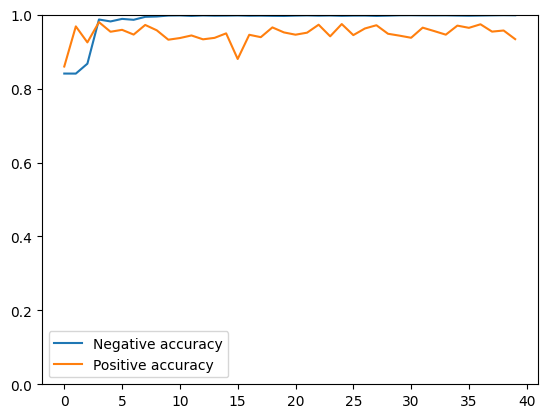

In [7]:
matrix1 = np.loadtxt("./model/negative_accuracy.txt")
matrix2 = np.loadtxt("./model/positive_accuracy.txt")

if len(matrix1.shape) > 1:
    averages1 = np.mean(matrix1, axis=0)
    averages2 = np.mean(matrix2, axis=0)
else:
    averages1 = matrix1
    averages2 = matrix2

plt.ylim(0, 1)
plt.plot(averages1, label='Negative accuracy')
plt.plot(averages2, label='Positive accuracy')

plt.legend()
plt.show()

In [3]:
# Create a nrrd file from a prediction based on the input directory
path = "./unprocessed_data/micro_ct_v2/volume_input.npy"
image_array = np.load(path)
name = path.split("/")[-2]

image_init = np.expand_dims(image_array, axis=0)
# Print the shape of the input and output arrays
shape = image_init.shape
print("Initial shape:", shape)

# Parameters
step_ratio = 1
step = int(step_ratio * config.HEIGHT)
margin = 0

# Create 0 copies of inputs
count_array = np.zeros_like(image_init)
total_array = np.zeros_like(image_init)

index = 0
if not os.path.exists("./nrrd"):
    os.makedirs("./nrrd")
nrrd_array = []
# Loop over the input images
for i in tqdm(range(0, shape[1] - shape[1] % 16, 16), "Processing"):
    for j in range(0, shape[2] - shape[2] % step , step):
        for k in range(0, shape[3] - shape[3] % step , step):
            slice_tmp = image_init[:, i : i + 16, j : j + config.HEIGHT, k : k + config.WIDTH]
            array_tmp = get_prediction(slice_tmp / 255, margin)[0]
            count_array[:, i : i + 16, j : j + config.HEIGHT, k : k + config.WIDTH] = array_tmp
            total_array[:, i : i + 16, j : j + config.HEIGHT, k : k + config.WIDTH] += 1
    
def calculate_binary_array(count_array, total_array):
    # Avoid division by zero by setting a mask for total_array equal to zero
    mask = total_array == False
    
    # Initialize binary_array with all zeros
    new_array = np.zeros_like(count_array)
    
    # Calculate binary_array where total_array is not zero
    new_array[~mask] = (count_array[~mask] / total_array[~mask]) >= 0.5
    
    return new_array

count_array = count_array.astype(np.uint8)
total_array = total_array.astype(np.uint8)
nrrd_array = calculate_binary_array(count_array, total_array)


# Transfer binary_array to nrrd
nrrd_array = np.array(nrrd_array)
# Create the folder if it doesn't exist
 
if not os.path.exists(f"./nrrd/{name}"):
    os.makedirs("./nrrd/{name}")

nrrd.write(f"./nrrd/{name}/orig.nrrd", nrrd_array)



Initial shape: (1, 1341, 1356, 1356)


Processing: 100%|██████████| 83/83 [2:03:44<00:00, 89.45s/it]  


In [13]:
def calculate_binary_array(count_array, total_array):
    # Avoid division by zero by setting a mask for total_array equal to zero
    mask = total_array == False
    
    # Initialize binary_array with all zeros
    new_array = np.zeros_like(count_array)
    
    # Calculate binary_array where total_array is not zero
    new_array[~mask] = (count_array[~mask] / total_array[~mask]) >= 0.5
    
    return new_array

count_array = count_array.astype(np.uint8)
total_array = total_array.astype(np.uint8)
nrrd_array = calculate_binary_array(count_array, total_array)


# Transfer binary_array to nrrd
nrrd_array = np.array(nrrd_array)
nrrd.write(f"./nrrd/{name}/orig.nrrd", nrrd_array + 1)

In [4]:

flipped = np.flip(np.moveaxis(np.flip(nrrd_array[0], axis=2), [0, -2], [2, 1]), axis=0)
nrrd.write(f"./nrrd/{name}/flipped.nrrd", flipped)

In [ ]:
# import cv2
# import os
# import nibabel as nib
# import numpy as np
# from tqdm import tqdm

# def nii_to_numpy(file_path):
#     # Load NRRD file
#     nrrd_data = nib.load(file_path)

#     # Get the data array from the NRRD file
#     nrrd_array = nrrd_data.get_fdata()

#     return nrrd_array

# # Example usage
# nrrd_file_path = "./single_image.nii"
# numpy_array = np.squeeze(nii_to_numpy(nrrd_file_path), axis=-1)

# img_name = "img_1000342.png"
# img1 = cv2.imread(os.path.join("./preparations/data/indata/", img_name), cv2.IMREAD_GRAYSCALE)
# img2 = cv2.imread(os.path.join("./preparations/data/outdata", img_name), cv2.IMREAD_GRAYSCALE)
# img3 = np.transpose(numpy_array * 255)

# size = (512, 512)
# min_err = 2e-10
# min_err_threshold = 256

# weight = 100


# _, img_threshold = cv2.threshold(img1, 61, 255, cv2.THRESH_BINARY)
# cv2.imshow("Original", cv2.resize(img1, size))
# cv2.imshow("Threshold", cv2.resize(img2, size))
# cv2.imshow("Manual", cv2.resize(img3, size))
# cv2.imshow("Closest", cv2.resize(img_threshold, size))
# cv2.waitKey()
# cv2.destroyAllWindows()

# # Create a new array with default values (255, 0, 0)
# result_array = np.full((img3.shape[0], img3.shape[1], 3), (0, 0, 255), dtype=np.uint8)

# # Update values based on conditions
# result_array[(img3 == 0) & (img_threshold == 0), :] = (0, 0, 0)  # Where both are 0
# result_array[(img3 == 255) & (img_threshold == 255), :] = (255, 255, 255)  # Where both are 255


# cv2.imshow("Errors", result_array)
# cv2.imwrite("./image_with_errors.png", result_array)
# cv2.waitKey()
# cv2.destroyAllWindows()

In [ ]:
# orig_data = os.listdir("Z://Artem/orig_data/")
# annotated_data = os.listdir("Z://Artem/annotated_data/")
# pic_in = cv2.imread("Z://Artem/orig_data/img_1000000.png", cv2.IMREAD_GRAYSCALE)
# pic_out = cv2.imread("Z://Artem/annotated_data/img_1000000.png", cv2.IMREAD_GRAYSCALE)
# pic_pred = cv2.imread("Z://Artem/CNN_data/img_1000000.png", cv2.IMREAD_GRAYSCALE)
# print(pic_in.shape)
# print(pic_out.shape)
# print(pic_pred.shape)

# orig_data = os.listdir("Z://Artem/orig_data/")
# annotated_data = os.listdir("Z://Artem/annotated_data/")

# step = 32

# # for x in tqdm(orig_data, ""):
# #     file_path = os.path.join("Z://Artem/orig_data/", x)
# #     pic = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
# #     height, width = pic.shape
# #     cv2.imwrite(file_path, pic[:height- height % step, :width - width % step])

# for x in tqdm(annotated_data, ""):
#     file_path = os.path.join("Z://Artem/annotated_data/", x)
#     pic = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
#     height, width = pic.shape
#     cv2.imwrite(file_path, pic[:height - height % step, :width - width % step])


In [9]:
import numpy as np
import cv2
import os

# import npy file and display first image from the array
npy_file_path_input = "./unprocessed_data/LSM/volume_input.npy"
npy_file_path_output = "./unprocessed_data/LSM/volume_ground_truth.npy"
npy_file_path = "./processed_npy/LSM.npy"

image_array = np.load(npy_file_path)
image_array1 = np.load(npy_file_path_input)
image_array2 = np.load(npy_file_path_output)

# apply pff

if True:
    # Apply Pseudo flat field correction
    blur_array = [cv2.GaussianBlur(image_array1[i], (7, 7), 0) for i in range(image_array.shape[0])]
    # normalize
    image_array1 = blur_array

index = 10
image = image_array[index]
image1 = image_array1[index]
image2 = image_array2[index]


cv2.imshow("image", image * 255 / np.max(image))
print(np.max(image))
cv2.imshow("image1", image1)
cv2.imshow("image2", image2 * 255)
cv2.waitKey()
cv2.destroyAllWindows()

1


In [22]:
# read the npy file from path

npy_file_path_output = "./unprocessed_data/LSM/volume_ground_truth.npy"

# load the npy file
image_array = np.load(npy_file_path_output)

# show all the images with delay of 2
for i in range(len(image_array)):
    image = image_array[i]
    cv2.imshow("image", image * 255)
    cv2.waitKey(15)

# close all the windows
cv2.destroyAllWindows()